In [1]:

%load_ext autoreload
%autoreload 2
import pandas as  pd
import numpy as np
from sklearn.metrics import precision_score
from hydra import compose, initialize
from hydra.utils import instantiate
import shap
import plotly.express as px


from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from Data_Collect_32.process_data.dataset import Dataset
from Data_Collect_32.process_data.data_splitter import data_splitter
from Data_Collect_32.process_data.data_window import add_normalized_cols, add_time_cols

In [3]:
initialize(config_path="../conf/")
cfg = compose(config_name='config.yaml')


The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1


In [4]:
pipeline = instantiate(cfg.data_pipeline)

In [5]:
df = pd.read_csv('../data/Data_collect_32.csv')
df = pipeline.apply(df.copy())

In [6]:
window = 10
model_features = [ 'rsi', 'mfi', 'regrs', 'cci']
model_features += ['rsi_norm_' + str(i) for i in range(0,window)]
model_features += ['mfi_norm_' + str(i) for i in range(0,window)]
model_features += ['williams_' + str(i) for i in range(0,window)]
model_features += ['tv_norm_' + str(i) for i in range(0,window)]
model_features += ['regrs_norm_' + str(i) for i in range(0,window)]
model_features += ['sma_norm_' + str(i) for i in range(0,window)]
model_features += ['cci_norm_' + str(i) for i in range(0,window)]
len(model_features)

74

In [7]:
dataset = Dataset(data = df, data_splitter = data_splitter)
clf = HistGradientBoostingClassifier( l2_regularization = 20, learning_rate=0.5, max_iter=20, max_leaf_nodes  = 20, max_depth=5, random_state=5).fit(dataset.X_train[model_features], dataset.y_train, sample_weight = dataset.X_train['sample_weight'])

Splitted data


In [8]:
HistGradientBoostingClassifier(**cfg.model.model_params)

HistGradientBoostingClassifier(l2_regularization=20, learning_rate=0.5,
                               max_bins=25, max_depth=5, max_iter=5,
                               max_leaf_nodes=66, min_samples_leaf=1,
                               random_state=1)

In [9]:
roc_test = roc_auc_score(dataset.y_train, clf.predict_proba(dataset.X_train[model_features]).T[1])
precision_test = precision_score(dataset.y_train, clf.predict(dataset.X_train[model_features]))

print(f'roc_test: {roc_test}')
print(f'precision_test: {precision_test}')

roc_test: 1.0
precision_test: 1.0


In [10]:
roc_test = roc_auc_score(dataset.y_test, clf.predict_proba(dataset.X_test[model_features]).T[1])
precision_test = precision_score(dataset.y_test, clf.predict(dataset.X_test[model_features]))

print(f'roc_test: {roc_test}')
print(f'precision_test: {precision_test}')

roc_test: 1.0
precision_test: 1.0


In [11]:
roc_test = roc_auc_score(dataset.y_oot, clf.predict_proba(dataset.X_oot[model_features]).T[1])
precision_test = precision_score(dataset.y_oot, clf.predict(dataset.X_oot[model_features]))

print(f'roc_oot: {roc_test}')
print(f'precision_oot: {precision_test}')

roc_oot: 0.9999999999999999
precision_oot: 1.0


In [12]:
# explainer = shap.TreeExplainer(clf, dataset.X_test[model_features])
# shap_values = explainer(dataset.X_train[model_features], check_additivity =  False)
# prediction = clf.predict_proba(dataset.X_train[model_features])
# shap.plots.beeswarm(shap_values, max_display=70)

<Axes: >

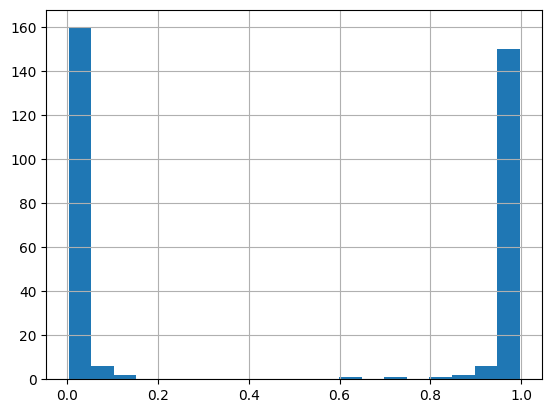

In [13]:
pd.Series(clf.predict_proba(dataset.X_test[model_features]).T[1]).hist(bins = 20)

In [14]:

pred = [1 if d > 0.8 else 0 for d in clf.predict_proba(dataset.X_oot[model_features]).T[1]]

In [15]:

from datetime import datetime
def calculate_time_difference(date_str1, date_str2):
    date_format = '%d.%m.%Y %H:%M:%S'
    dates = dataset.X_oot['Datum'].apply(lambda x: datetime.strptime(x, date_format))
    date1 = min(dates)
    date2 = max(dates)
    
    time_difference = date2 - date1
    
    days = time_difference.days
    
    print(date1)
    print(date2)
    return {'days': days,}


In [16]:
dataset.X_oot['diff'] = dataset.X_oot['next_close_price'] - dataset.X_oot['close_price']
dataset.X_oot['pred'] = pred
print( sum(dataset.X_oot['diff'][dataset.X_oot['pred'] ==1]) - sum(pred)*0.00006)
final_pred =dataset.X_oot['diff'][dataset.X_oot['pred'] ==1] -0.00006
px.line(final_pred.cumsum(axis = 0))

0.3558400000000001


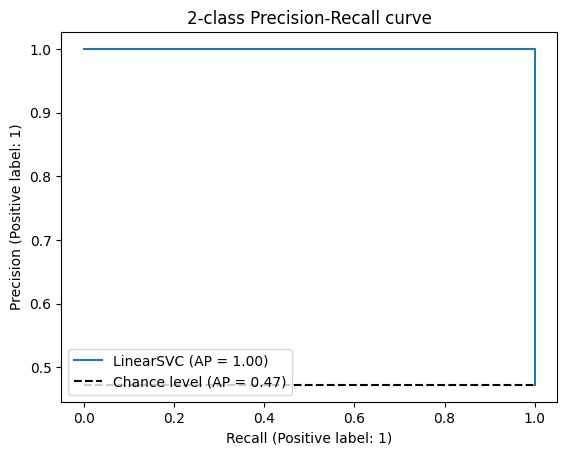

In [17]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    clf, dataset.X_oot[model_features], dataset.y_oot, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

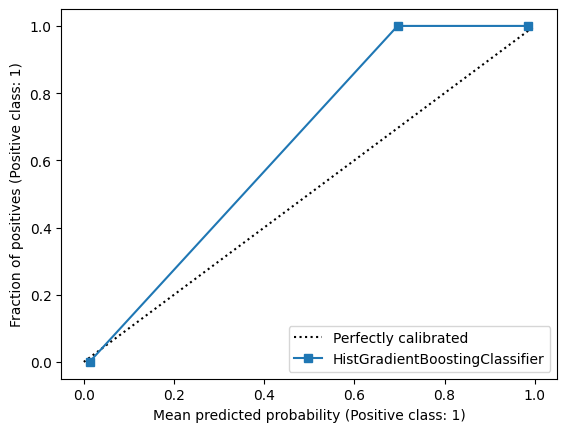

In [18]:
disp = CalibrationDisplay.from_estimator(clf, dataset.X_test[model_features], dataset.y_test)

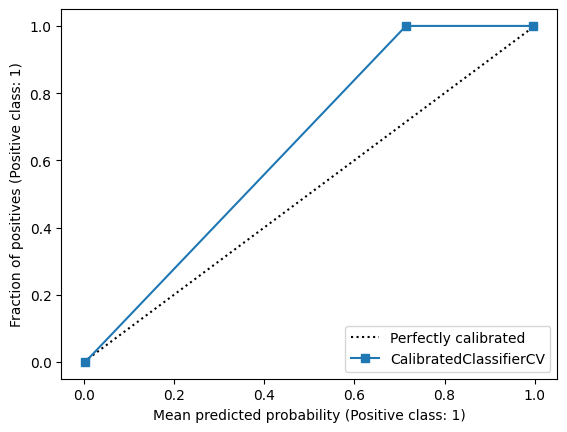

In [19]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(clf, cv='prefit')
calibrated_clf.fit(dataset.X_train[model_features], dataset.y_train)
disp = CalibrationDisplay.from_estimator(calibrated_clf, dataset.X_test[model_features], dataset.y_test)

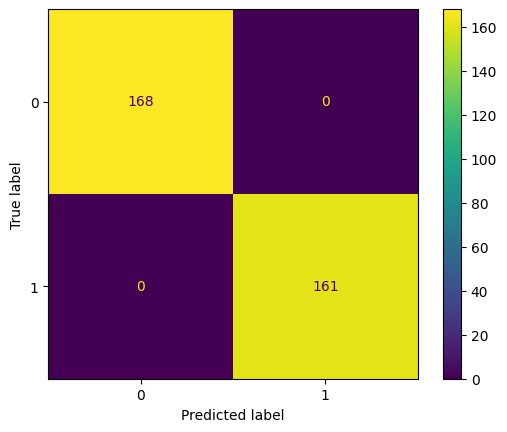

In [20]:
cm = confusion_matrix(dataset.y_test, calibrated_clf.predict(dataset.X_test[model_features]))
ConfusionMatrixDisplay(cm).plot()

In [21]:
pred = [1 if d > 0.95 else 0 for d in calibrated_clf.predict_proba(dataset.X_oot[model_features]).T[1]]

<Axes: >

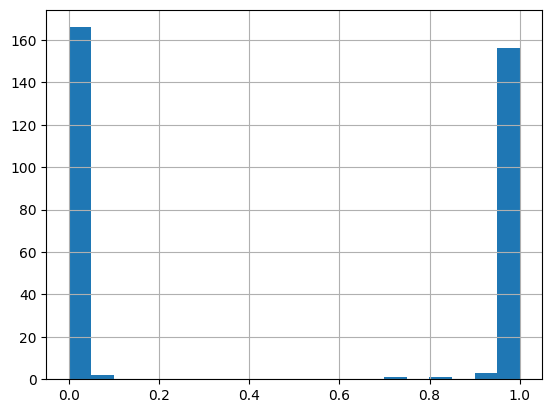

In [22]:
pd.Series(calibrated_clf.predict_proba(dataset.X_test[model_features]).T[1]).hist(bins = 20)

In [23]:
from sklearn.calibration import calibration_curve

In [24]:
from sklearn.metrics import log_loss

In [25]:
calibration_curve(dataset.y_test, calibrated_clf.predict_proba(dataset.X_test[model_features]).T[1])

(array([0., 1., 1.]), array([0.00329139, 0.71444598, 0.99508433]))

In [26]:
log_loss(dataset.y_test, clf.predict_proba(dataset.X_test[model_features]).T[1])

0.016339204799105986

In [35]:
test_DF = dataset.X_train[model_features].iloc[0]

In [51]:
test_DF

rsi            54.900000
mfi            64.265029
regrs           0.191601
cci            52.631579
rsi_norm_0      4.799213
                 ...    
cci_norm_5   -382.575141
cci_norm_6   -404.545123
cci_norm_7   -429.227997
cci_norm_8   -463.829360
cci_norm_9   -462.755074
Name: 1544, Length: 74, dtype: float64

In [48]:
test_DF.to_json("testdf.json")

In [52]:
 pd.read_json("testdf.json", orient = 'index').T

,rsi,mfi,regrs,cci,rsi_norm_0,rsi_norm_1,rsi_norm_2,rsi_norm_3,rsi_norm_4,rsi_norm_5,...,cci_norm_0,cci_norm_1,cci_norm_2,cci_norm_3,cci_norm_4,cci_norm_5,cci_norm_6,cci_norm_7,cci_norm_8,cci_norm_9
0,54.9,64.265029,0.191601,52.631579,4.799213,5.925984,7.13622,8.346457,9.640157,11.017323,...,-277.79785,-300.907387,-321.325293,-340.984862,-361.241503,-382.575141,-404.545123,-429.227997,-463.82936,-462.755074


In [55]:
import json
with open('testdf.json', 'r') as file:
            input_data = json.load(file)

In [56]:
input_data

{'rsi': 54.9,
 'mfi': 64.265029,
 'regrs': 0.191601,
 'cci': 52.631579,
 'rsi_norm_0': 4.7992125984,
 'rsi_norm_1': 5.925984252,
 'rsi_norm_2': 7.1362204724,
 'rsi_norm_3': 8.3464566929,
 'rsi_norm_4': 9.6401574803,
 'rsi_norm_5': 11.0173228346,
 'rsi_norm_6': 12.4362204724,
 'rsi_norm_7': 13.8968503937,
 'rsi_norm_8': 17.068503937,
 'rsi_norm_9': 16.442519685,
 'mfi_norm_0': 3.3234477909,
 'mfi_norm_1': 4.4254354218,
 'mfi_norm_2': 5.5261688512,
 'mfi_norm_3': 6.6265184109,
 'mfi_norm_4': 7.727353503,
 'mfi_norm_5': 8.8295439944,
 'mfi_norm_6': 9.9339634712,
 'mfi_norm_7': 11.0414914089,
 'mfi_norm_8': 12.1530150313,
 'mfi_norm_9': 12.151248952,
 'williams_0': -100.0,
 'williams_1': -100.0,
 'williams_2': -100.0,
 'williams_3': -85.714286,
 'williams_4': -62.5,
 'williams_5': -44.444444,
 'williams_6': -30.0,
 'williams_7': -18.181818,
 'williams_8': 0.0,
 'williams_9': 0.0,
 'tv_norm_0': 0.0,
 'tv_norm_1': 0.0,
 'tv_norm_2': 0.0,
 'tv_norm_3': 0.0,
 'tv_norm_4': 0.0,
 'tv_norm_5': 0.

In [59]:
pd.DataFrame.from_dict(input_data, orient="index").T

,rsi,mfi,regrs,cci,rsi_norm_0,rsi_norm_1,rsi_norm_2,rsi_norm_3,rsi_norm_4,rsi_norm_5,...,cci_norm_0,cci_norm_1,cci_norm_2,cci_norm_3,cci_norm_4,cci_norm_5,cci_norm_6,cci_norm_7,cci_norm_8,cci_norm_9
0,54.9,64.265029,0.191601,52.631579,4.799213,5.925984,7.13622,8.346457,9.640157,11.017323,...,-277.79785,-300.907387,-321.325293,-340.984862,-361.241503,-382.575141,-404.545123,-429.227997,-463.82936,-462.755074


In [61]:
import joblib


joblib.dump(clf, 'model.pkl')

['model.pkl']

In [63]:
len(clf.feature_names_in_)

74